In [40]:
import lib.time_logger as TLOG
from lib.core import *
import os
import json
from collections import defaultdict
import pandas as pd
import numpy as np
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.text import Text
from rich.progress import track
from rich import box
from rich.columns import Columns
from rich.theme import Theme
from rich.style import Style

# Initialize Rich console with a custom theme
dracula_theme = Theme(
    {
        "info": "bold #8be9fd",  # Cyan
        "warning": "bold #f1fa8c",  # Yellow
        "error": "bold #ff5555",  # Red
        "success": "bold #50fa7b",  # Green
        "attacker": "bold #ff79c6",  # Pink
        "defender": "bold #bd93f9",  # Purple
        "header": "bold #f8f8f2 on #44475a",  # Foreground on Current Line
        "setup": "bold #f8f8f2 on #6272a4",  # Foreground on Comment
        "value_high": "bold #50fa7b",  # Green
        "value_medium": "bold #f1fa8c",  # Yellow
        "value_low": "bold #ff5555",  # Red
        "title": "bold #f8f8f2 on #6272a4",  # Foreground on Comment
    }
)

console = Console(theme=dracula_theme)
DATA_PATH = os.path.join("data", "result_v1.1.1")


def extract_setup_key(metadata):
    """Extract only the setup parameters from metadata, excluding strategies."""
    setup_params = {}
    for key, value in metadata.items():
        if key not in ["attacker_strategy", "defender_strategy"]:
            setup_params[key] = value
    return json.dumps(setup_params, sort_keys=True)


def create_strategy_matrix():
    """
    Group files by unique setups and create matrices of attacker vs defender strategies.
    """
    console.print(Panel(f"Reading JSON files from: [bold]{DATA_PATH}[/bold]", title="Data Analysis", style="info"))

    # Check if directory exists
    if not os.path.exists(DATA_PATH):
        console.print(f"[error]Directory {DATA_PATH} does not exist.[/error]")
        return {}, set(), set()

    # Data structures to store results by setup and strategies
    setups = {}  # Will store {setup_key: {(attacker, defender): [stats]}}

    # Collect all unique attacker and defender strategies
    all_attackers = set()
    all_defenders = set()

    # Get file list first for progress tracking
    json_files = [f for f in os.listdir(DATA_PATH) if f.endswith(".json")]

    # Process all JSON files with progress bar
    for filename in track(json_files, description="Processing files"):
        filepath = os.path.join(DATA_PATH, filename)

        # Skip empty files
        if os.path.getsize(filepath) == 0:
            console.print(f"[warning]File {filename} is empty. Skipping.[/warning]")
            continue

        try:
            # Create TimeLogger instance and read the file
            logger = TLOG.TimeLogger(name=filename)
            logger.path = DATA_PATH
            logger.read_from_file(filename)

            # Get metadata
            metadata = logger.get_metadata()

            # Skip if missing critical metadata
            if "attacker_strategy" not in metadata or "defender_strategy" not in metadata:
                console.print(f"[warning]File {filename} is missing strategy information. Skipping.[/warning]")
                continue

            # Extract setup key (everything except strategies)
            setup_key = extract_setup_key(metadata)

            # Extract strategy info
            attacker = metadata.get("attacker_strategy")
            defender = metadata.get("defender_strategy")

            # Add to our sets of all strategies
            all_attackers.add(attacker)
            all_defenders.add(defender)

            # Initialize setup entry if needed
            if setup_key not in setups:
                setups[setup_key] = {}

            # Get strategy pair key
            strategy_pair = (attacker, defender)

            # Extract summary records
            summary_records = logger.extract_summary()

            # If there are summary records, add them to the appropriate group
            if summary_records:
                for summary in summary_records:
                    # Check if it has the keys we're interested in
                    if any(key in summary for key in ["payoff", "time", "total_captures", "total_tags"]):
                        if strategy_pair not in setups[setup_key]:
                            setups[setup_key][strategy_pair] = []
                        setups[setup_key][strategy_pair].append(summary)

        except Exception as e:
            console.print(f"[error]Error processing file {filename}: {str(e)}[/error]")

    # For each setup, calculate averages for each strategy pair
    results = {}

    for setup_key, strategy_data in setups.items():
        setup_dict = json.loads(setup_key)

        # Create a strategy matrix for this setup
        attackers = sorted(all_attackers)
        defenders = sorted(all_defenders)

        # Create a matrix for each stat
        payoff_matrix = pd.DataFrame(index=defenders, columns=attackers)
        time_matrix = pd.DataFrame(index=defenders, columns=attackers)
        captures_matrix = pd.DataFrame(index=defenders, columns=attackers)
        tags_matrix = pd.DataFrame(index=defenders, columns=attackers)

        # Fill the matrices
        for (attacker, defender), summaries in strategy_data.items():
            # Skip pairs that don't have summary data
            if not summaries:
                continue

            # Calculate the sum of each metric
            payoff_sum = sum(s.get("payoff", 0) for s in summaries if "payoff" in s)
            time_sum = sum(s.get("time", 0) for s in summaries if "time" in s)
            captures_sum = sum(s.get("total_captures", 0) for s in summaries if "total_captures" in s)
            tags_sum = sum(s.get("total_tags", 0) for s in summaries if "total_tags" in s)

            count = len(summaries)

            payoff_matrix.loc[defender, attacker] = round(payoff_sum / count, 2) if count > 0 else np.nan
            time_matrix.loc[defender, attacker] = round(time_sum / count, 2) if count > 0 else np.nan
            captures_matrix.loc[defender, attacker] = round(captures_sum / count, 2) if count > 0 else np.nan
            tags_matrix.loc[defender, attacker] = round(tags_sum / count, 2) if count > 0 else np.nan

        # Store results for this setup
        results[setup_key] = {"setup": setup_dict, "payoff_matrix": payoff_matrix, "time_matrix": time_matrix, "captures_matrix": captures_matrix, "tags_matrix": tags_matrix}

    return results, all_attackers, all_defenders


def get_value_style(value, metric_type):
    """Determine the style for a value based on its magnitude and metric type."""
    if pd.isna(value):
        return "dim"

    if metric_type == "payoff":
        if value > 0.7:
            return "value_high"
        elif value > 0.3:
            return "value_medium"
        else:
            return "value_low"
    elif metric_type == "time":
        # Assuming lower time is better
        if value < 50:
            return "value_high"
        elif value < 100:
            return "value_medium"
        else:
            return "value_low"
    elif metric_type in ["captures", "tags"]:
        # Assuming higher is better for these
        if value > 5:
            return "value_high"
        elif value > 2:
            return "value_medium"
        else:
            return "value_low"

    return None


def display_rich_matrices(results):
    """
    Display matrices with Rich formatting in a more compact way for Jupyter notebooks.
    """
    if not results:
        console.print("[error]No results to display.[/error]")
        return

    for setup_idx, (setup_key, data) in enumerate(results.items(), 1):
        # Create a title for the setup with smaller spacing
        setup_title = Text(f"SETUP {setup_idx}", style="setup")
        console.print(setup_title, justify="center")

        # Print setup details in a more compact panel
        setup = data["setup"]
        setup_details = Table.grid(padding=0)
        setup_details.add_column("Parameter", style="bold #8be9fd")
        setup_details.add_column("Value", style="bold #f8f8f2")

        for key, value in setup.items():
            setup_details.add_row(str(key), str(value))

        console.print(Panel(setup_details, title="Game Configuration", border_style="#50fa7b", padding=(0, 1)))

        # Get matrices
        payoff = data["payoff_matrix"]
        time = data["time_matrix"]
        captures = data["captures_matrix"]
        tags = data["tags_matrix"]

        # Create tabs-like display with all matrices
        console.print(Text("STATISTICS MATRICES", style="title"), justify="center")

        # Create more compact tables
        tables = []

        # PAYOFF MATRIX - More compact
        payoff_table = Table(box=box.SIMPLE, title="PAYOFF", title_style="#ff79c6", padding=(0, 1))

        # Add columns with smaller width
        payoff_table.add_column("Def", style="defender", width=8)
        for attacker in payoff.columns:
            payoff_table.add_column(attacker[:8], style="attacker", width=8)

        # Add rows with compact formatting
        for defender in payoff.index:
            row_data = [defender[:8]]  # Truncate long names
            for attacker in payoff.columns:
                value = payoff.loc[defender, attacker]
                if pd.isna(value):
                    row_data.append("-")
                else:
                    row_data.append(f"{value:.1f}")
            payoff_table.add_row(*row_data)

        tables.append(payoff_table)

        # TIME MATRIX - More compact
        time_table = Table(box=box.SIMPLE, title="TIME", title_style="#ff79c6", padding=(0, 1))

        time_table.add_column("Def", style="defender", width=8)
        for attacker in time.columns:
            time_table.add_column(attacker[:8], style="attacker", width=8)

        for defender in time.index:
            row_data = [defender[:8]]
            for attacker in time.columns:
                value = time.loc[defender, attacker]
                if pd.isna(value):
                    row_data.append("-")
                else:
                    row_data.append(f"{value:.1f}")
            time_table.add_row(*row_data)

        tables.append(time_table)

        # Display tables in columns for horizontal space efficiency
        console.print(Columns(tables, padding=1))

        # CAPTURES & TAGS - Compact
        captures_table = Table(box=box.SIMPLE, title="CAPTURES", title_style="#ff79c6", padding=(0, 1))
        captures_table.add_column("Def", style="defender", width=8)
        for attacker in captures.columns:
            captures_table.add_column(attacker[:8], style="attacker", width=8)

        for defender in captures.index:
            row_data = [defender[:8]]
            for attacker in captures.columns:
                value = captures.loc[defender, attacker]
                if pd.isna(value):
                    row_data.append("-")
                else:
                    row_data.append(f"{value:.1f}")
            captures_table.add_row(*row_data)

        tags_table = Table(box=box.SIMPLE, title="TAGS", title_style="#ff79c6", padding=(0, 1))
        tags_table.add_column("Def", style="defender", width=8)
        for attacker in tags.columns:
            tags_table.add_column(attacker[:8], style="attacker", width=8)

        for defender in tags.index:
            row_data = [defender[:8]]
            for attacker in tags.columns:
                value = tags.loc[defender, attacker]
                if pd.isna(value):
                    row_data.append("-")
                else:
                    row_data.append(f"{value:.1f}")
            tags_table.add_row(*row_data)

        console.print(Columns([captures_table, tags_table], padding=1))

        # Display a separator between setups
        if setup_idx < len(results):
            console.rule(style="#44475a")


def generate_summary_stats(results, all_attackers, all_defenders):
    """Generate and display compact summary statistics about the data."""
    summary_title = Text("SUMMARY", style="title")
    console.print(summary_title, justify="center")
    
    # Create a more compact summary table
    summary_table = Table(box=box.SIMPLE, padding=(0,1))
    summary_table.add_column("Metric", style="#8be9fd")
    summary_table.add_column("Value", style="#f8f8f2")
    
    summary_table.add_row("Game Setups", str(len(results)))
    summary_table.add_row("Attacker Strategies", str(len(all_attackers)))
    summary_table.add_row("Defender Strategies", str(len(all_defenders)))
    
    console.print(summary_table)
    
    # More compact strategies display
    strat_table = Table(box=box.SIMPLE, padding=(0,1))
    strat_table.add_column("Attackers", style="#ff79c6")
    strat_table.add_column("Defenders", style="#bd93f9")
    
    # Zip the strategies side by side with proper padding
    attackers_list = sorted(all_attackers)
    defenders_list = sorted(all_defenders)
    
    # Fill the shorter list with empty strings to match lengths
    max_len = max(len(attackers_list), len(defenders_list))
    attackers_padded = attackers_list + [''] * (max_len - len(attackers_list))
    defenders_padded = defenders_list + [''] * (max_len - len(defenders_list))
    
    for att, def_ in zip(attackers_padded, defenders_padded):
        strat_table.add_row(att, def_)
    
    console.print(strat_table)


def run_analysis_for_jupyter():
    """Run analysis with optimized display for Jupyter notebooks"""
    try:
        console.rule("[bold]Strategy Analysis[/bold]")
        results, all_attackers, all_defenders = create_strategy_matrix()
        generate_summary_stats(results, all_attackers, all_defenders)
        display_rich_matrices(results)
        console.rule("[bold #50fa7b]Analysis Complete[/bold #50fa7b]")
        return results
    except Exception as e:
        console.print(f"[error]Error: {str(e)}[/error]")
        console.print_exception()


results = run_analysis_for_jupyter()

──────────────────────────────────────────────── Strategy Analysis ────────────────────────────────────────────────

╭───────────────────────────────────────────────── Data Analysis ─────────────────────────────────────────────────╮
│ Reading JSON files from: data/result_v1.1.1                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

SUMMARY

 Metric                Value  
 ───────────────────────────── 
  Game Setups           8      
  Attacker Strategies   4      
  Defender Strategies   4     

 Attackers          Defenders         
 ───────────────────────────────────── 
  Example_Attacker   Example_Defender  
  GMU_Attacker       GMU_Defender      
  MSU_Attacker       MSU_Defender      
  UNCC_Attacker      UNCC_Defender    

SETUP 1

╭────────────────────────────────────────────── Game Configuration ───────────────────────────────────────────────╮
│ attacker_dist_typenormal                                                                                        │
│ attacker_num      1                                                                                             │
│ attacker_param    [7, 3]                                                                                        │
│ defender_dist_typenormal                                                                                        │
│ defender_num      1                                                                                             │
│ defender_param    [4, 2]                                                                                        │
│ flag_dist_type    uniform                                                                                       │
│ flag_num          1                                                                                             │
│ flag_param        2                                                                                             │
│ graph_file        graph_200_200.pkl                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

STATISTICS MATRICES

                         PAYOFF                                                    TIME                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   -0.1       -0.1       -0.1       -0.1         Example_   4.0        4.0        4.0        4.0       
  GMU_Defe   -0.1       -0.1       -0.1       -0.1         GMU_Defe   5.4        5.3        5.4        5.4       
  MSU_Defe   0.5        0.5        0.5        0.5          MSU_Defe   6.1        5.8        6.1        6.1       
  UNCC_Def   -0.1       -0.1       -0.1       -0.1         UNCC_Def   4.4        4.4        4.4        4.4      

                        CAPTURES                                                   TAGS                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   0.3        0.3        0.3        0.3          Example_   0.7        0.7        0.7        0.7       
  GMU_Defe   0.3        0.2        0.3        0.3          GMU_Defe   0.7        0.8        0.7        0.7       
  MSU_Defe   0.7        0.6        0.7        0.7          MSU_Defe   0.3        0.4        0.3        0.3       
  UNCC_Def   0.3        0.3        0.3        0.3          UNCC_Def   0.7        0.7        0.7        0.7      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

SETUP 2

╭────────────────────────────────────────────── Game Configuration ───────────────────────────────────────────────╮
│ attacker_dist_typenormal                                                                                        │
│ attacker_num      5                                                                                             │
│ attacker_param    [7, 3]                                                                                        │
│ defender_dist_typenormal                                                                                        │
│ defender_num      5                                                                                             │
│ defender_param    [4, 2]                                                                                        │
│ flag_dist_type    uniform                                                                                       │
│ flag_num          3                                                                                             │
│ flag_param        2                                                                                             │
│ graph_file        graph_200_200.pkl                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

STATISTICS MATRICES

                         PAYOFF                                                    TIME                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   -0.1       0.3        -0.1       -0.1         Example_   7.9        7.9        7.9        7.9       
  GMU_Defe   -0.6       -0.5       -0.6       -0.6         GMU_Defe   8.1        7.8        8.1        8.1       
  MSU_Defe   0.1        0.4        -0.2       0.0          MSU_Defe   8.0        7.9        8.2        8.0       
  UNCC_Def   -0.4       -0.5       -0.4       -0.4         UNCC_Def   7.5        7.6        7.5        7.5      

                        CAPTURES                                                   TAGS                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   1.8        2.1        1.8        1.8          Example_   3.7        3.5        3.7        3.7       
  GMU_Defe   1.4        1.4        1.4        1.4          GMU_Defe   3.9        3.9        3.9        3.9       
  MSU_Defe   1.9        2.1        1.6        1.8          MSU_Defe   3.6        3.4        3.8        3.6       
  UNCC_Def   1.5        1.5        1.5        1.5          UNCC_Def   3.8        3.8        3.8        3.8      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

SETUP 3

╭────────────────────────────────────────────── Game Configuration ───────────────────────────────────────────────╮
│ attacker_dist_typenormal                                                                                        │
│ attacker_num      10                                                                                            │
│ attacker_param    [7, 3]                                                                                        │
│ defender_dist_typenormal                                                                                        │
│ defender_num      10                                                                                            │
│ defender_param    [4, 2]                                                                                        │
│ flag_dist_type    uniform                                                                                       │
│ flag_num          5                                                                                             │
│ flag_param        2                                                                                             │
│ graph_file        graph_200_200.pkl                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

STATISTICS MATRICES

                         PAYOFF                                                    TIME                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   -0.6       0.4        -0.7       -0.6         Example_   8.8        8.6        8.8        8.8       
  GMU_Defe   -1.1       -1.1       -1.1       -1.1         GMU_Defe   8.7        8.5        8.8        8.7       
  MSU_Defe   -0.8       -0.0       -0.5       -0.6         MSU_Defe   8.2        8.0        8.2        8.2       
  UNCC_Def   -0.6       -0.8       -0.6       -0.6         UNCC_Def   8.6        8.7        8.7        8.6      

                        CAPTURES                                                   TAGS                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   3.2        4.0        3.2        3.2          Example_   7.8        7.1        7.8        7.8       
  GMU_Defe   2.9        2.9        2.9        2.9          GMU_Defe   8.1        8.0        8.1        8.1       
  MSU_Defe   3.1        3.7        3.4        3.3          MSU_Defe   7.9        7.4        7.7        7.8       
  UNCC_Def   3.3        3.1        3.3        3.3          UNCC_Def   7.7        7.8        7.7        7.7      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

SETUP 4

╭────────────────────────────────────────────── Game Configuration ───────────────────────────────────────────────╮
│ attacker_dist_typenormal                                                                                        │
│ attacker_num      2                                                                                             │
│ attacker_param    [7, 3]                                                                                        │
│ defender_dist_typenormal                                                                                        │
│ defender_num      2                                                                                             │
│ defender_param    [4, 2]                                                                                        │
│ flag_dist_type    uniform                                                                                       │
│ flag_num          1                                                                                             │
│ flag_param        2                                                                                             │
│ graph_file        graph_200_200.pkl                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

STATISTICS MATRICES

                         PAYOFF                                                    TIME                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   -0.1       0.0        -0.1       -0.1         Example_   5.8        5.7        5.8        5.8       
  GMU_Defe   -0.0       -0.0       -0.0       -0.0         GMU_Defe   6.4        6.2        6.4        6.4       
  MSU_Defe   0.3        0.4        0.3        0.3          MSU_Defe   7.1        6.8        7.1        7.1       
  UNCC_Def   -0.2       -0.2       -0.2       -0.2         UNCC_Def   5.8        5.7        5.8        5.8      

                        CAPTURES                                                   TAGS                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   0.6        0.7        0.6        0.6          Example_   1.4        1.3        1.4        1.4       
  GMU_Defe   0.6        0.6        0.6        0.6          GMU_Defe   1.4        1.4        1.4        1.4       
  MSU_Defe   0.9        1.0        0.9        0.9          MSU_Defe   1.1        1.0        1.1        1.1       
  UNCC_Def   0.6        0.6        0.6        0.6          UNCC_Def   1.4        1.4        1.4        1.4      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

SETUP 5

╭────────────────────────────────────────────── Game Configuration ───────────────────────────────────────────────╮
│ attacker_dist_typenormal                                                                                        │
│ attacker_num      10                                                                                            │
│ attacker_param    [7, 3]                                                                                        │
│ defender_dist_typenormal                                                                                        │
│ defender_num      10                                                                                            │
│ defender_param    [4, 2]                                                                                        │
│ flag_dist_type    uniform                                                                                       │
│ flag_num          3                                                                                             │
│ flag_param        2                                                                                             │
│ graph_file        graph_200_200.pkl                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

STATISTICS MATRICES

                         PAYOFF                                                    TIME                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   -2.4       -1.4       -2.3       -2.4         Example_   9.2        9.0        9.3        9.2       
  GMU_Defe   -2.5       -2.8       -2.6       -2.5         GMU_Defe   9.5        8.9        9.5        9.5       
  MSU_Defe   -1.9       -1.3       -2.0       -1.9         MSU_Defe   9.4        9.0        9.6        9.5       
  UNCC_Def   -2.7       -2.4       -2.7       -2.7         UNCC_Def   9.0        12.5       9.0        9.0      

                        CAPTURES                                                   TAGS                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   1.9        2.5        1.9        1.9          Example_   8.4        7.9        8.4        8.4       
  GMU_Defe   1.7        1.5        1.7        1.7          GMU_Defe   8.5        8.7        8.6        8.5       
  MSU_Defe   2.2        2.6        2.1        2.2          MSU_Defe   8.2        7.8        8.2        8.2       
  UNCC_Def   1.7        1.8        1.7        1.7          UNCC_Def   8.7        8.4        8.7        8.7      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

SETUP 6

╭────────────────────────────────────────────── Game Configuration ───────────────────────────────────────────────╮
│ attacker_dist_typenormal                                                                                        │
│ attacker_num      5                                                                                             │
│ attacker_param    [7, 3]                                                                                        │
│ defender_dist_typenormal                                                                                        │
│ defender_num      5                                                                                             │
│ defender_param    [4, 2]                                                                                        │
│ flag_dist_type    uniform                                                                                       │
│ flag_num          1                                                                                             │
│ flag_param        2                                                                                             │
│ graph_file        graph_200_200.pkl                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

STATISTICS MATRICES

                         PAYOFF                                                    TIME                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   -1.4       -1.1       -1.4       -1.4         Example_   8.8        8.5        8.8        8.8       
  GMU_Defe   -1.2       -1.2       -1.2       -1.2         GMU_Defe   9.2        8.9        9.2        9.2       
  MSU_Defe   -0.6       -0.5       -0.6       -0.6         MSU_Defe   10.2       9.7        10.2       10.2      
  UNCC_Def   -1.3       -1.3       -1.3       -1.3         UNCC_Def   8.3        8.1        8.3        8.3      

                        CAPTURES                                                   TAGS                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   0.7        0.9        0.7        0.7          Example_   4.3        4.1        4.3        4.3       
  GMU_Defe   0.8        0.9        0.8        0.8          GMU_Defe   4.2        4.1        4.2        4.2       
  MSU_Defe   1.2        1.3        1.2        1.2          MSU_Defe   3.8        3.7        3.8        3.8       
  UNCC_Def   0.8        0.8        0.8        0.8          UNCC_Def   4.2        4.2        4.2        4.2      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

SETUP 7

╭────────────────────────────────────────────── Game Configuration ───────────────────────────────────────────────╮
│ attacker_dist_typenormal                                                                                        │
│ attacker_num      10                                                                                            │
│ attacker_param    [7, 3]                                                                                        │
│ defender_dist_typenormal                                                                                        │
│ defender_num      10                                                                                            │
│ defender_param    [4, 2]                                                                                        │
│ flag_dist_type    uniform                                                                                       │
│ flag_num          1                                                                                             │
│ flag_param        2                                                                                             │
│ graph_file        graph_200_200.pkl                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

STATISTICS MATRICES

                         PAYOFF                                                    TIME                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   -3.2       -2.7       -3.2       -3.2         Example_   9.8        9.6        9.8        9.8       
  GMU_Defe   -2.8       -2.9       -2.8       -2.8         GMU_Defe   10.4       10.0       10.4       10.4      
  MSU_Defe   -2.4       -2.0       -2.4       -2.4         MSU_Defe   11.0       10.5       11.0       11.0      
  UNCC_Def   -3.4       -2.9       -3.4       -3.4         UNCC_Def   9.8        13.2       9.8        9.8      

                        CAPTURES                                                   TAGS                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   1.2        1.5        1.2        1.2          Example_   8.8        8.5        8.8        8.8       
  GMU_Defe   1.5        1.4        1.5        1.5          GMU_Defe   8.5        8.6        8.5        8.5       
  MSU_Defe   1.7        2.0        1.7        1.7          MSU_Defe   8.3        8.0        8.3        8.3       
  UNCC_Def   1.1        1.4        1.1        1.1          UNCC_Def   8.9        8.6        8.9        8.9      

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

SETUP 8

╭────────────────────────────────────────────── Game Configuration ───────────────────────────────────────────────╮
│ attacker_dist_typenormal                                                                                        │
│ attacker_num      5                                                                                             │
│ attacker_param    [7, 3]                                                                                        │
│ defender_dist_typenormal                                                                                        │
│ defender_num      5                                                                                             │
│ defender_param    [4, 2]                                                                                        │
│ flag_dist_type    uniform                                                                                       │
│ flag_num          5                                                                                             │
│ flag_param        2                                                                                             │
│ graph_file        graph_200_200.pkl                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

STATISTICS MATRICES

                         PAYOFF                                                    TIME                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   0.4        1.1        0.4        0.4          Example_   7.3        7.4        7.3        7.3       
  GMU_Defe   0.8        0.4        0.7        0.8          GMU_Defe   7.5        7.3        7.6        7.5       
  MSU_Defe   0.5        1.0        0.5        0.3          MSU_Defe   7.3        7.2        7.3        7.2       
  UNCC_Def   0.1        0.4        0.0        0.1          UNCC_Def   7.1        11.1       7.2        7.1      

                        CAPTURES                                                   TAGS                          
                                                                                                                 
  Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att     Def        Example_   GMU_Atta   MSU_Atta   UNCC_Att  
 ──────────────────────────────────────────────────────   ────────────────────────────────────────────────────── 
  Example_   2.1        2.6        2.1        2.1          Example_   3.5        3.1        3.5        3.5       
  GMU_Defe   2.5        2.2        2.4        2.5          GMU_Defe   3.4        3.5        3.4        3.4       
  MSU_Defe   2.2        2.6        2.2        2.1          MSU_Defe   3.4        3.1        3.4        3.5       
  UNCC_Def   1.9        2.1        1.9        1.9          UNCC_Def   3.6        3.5        3.7        3.6      

──────────────────────────────────────────────── Analysis Complete ────────────────────────────────────────────────

Found 8 unique game setups.

Found 0 unique attacker strategies:

Found 0 unique defender strategies:

/var/folders/bs/zn3fwrz921x5fqlm7rs064wm0000gn/T/ipykernel_93707/3138008330.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.95])


Visualization saved as data/000_raw_payoff_matrix.png

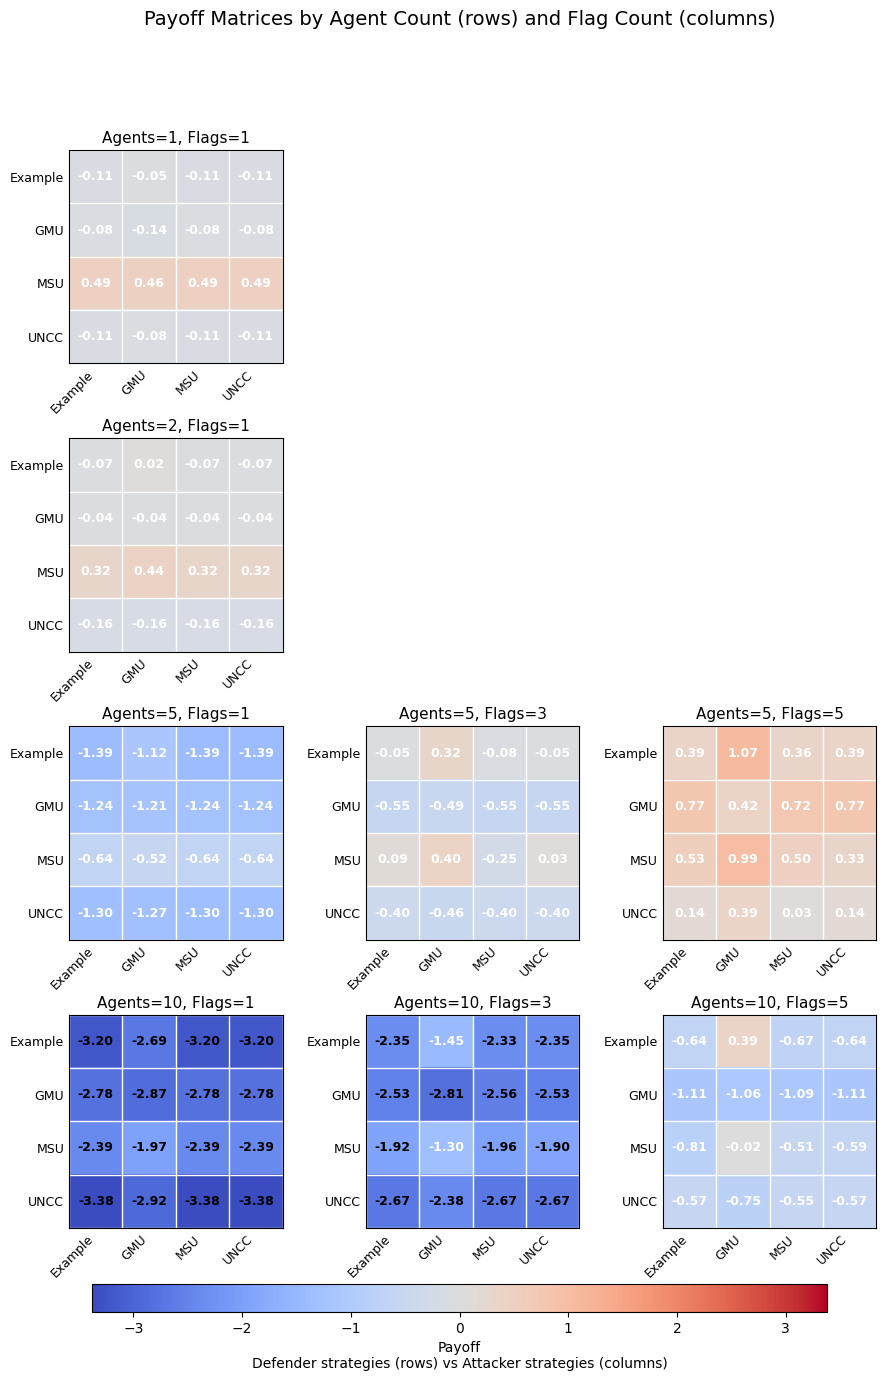

In [41]:
# Import additional packages needed for visualization
from rich.console import Console
from rich.panel import Panel
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os

# Initialize Rich console with Dracula theme colors
console = Console(theme=dracula_theme)


def organize_by_agents_and_flags(results):
    """
    Organize results by agent numbers and flag numbers.
    Returns a dictionary with (agent_num, flag_num) as keys.
    """
    organized_results = {}

    for setup_key, data in results.items():
        setup = data["setup"]

        # Extract agent and flag numbers
        agent_num = setup.get("attacker_num")
        flag_num = setup.get("flag_num")

        # Skip if missing necessary information
        if agent_num is None or flag_num is None:
            continue

        # Convert to integers if they're strings
        if isinstance(agent_num, str):
            agent_num = int(agent_num)
        if isinstance(flag_num, str):
            flag_num = int(flag_num)

        # Store the result
        key = (agent_num, flag_num)
        if key not in organized_results:
            organized_results[key] = []

        organized_results[key].append({"setup": setup, "payoff_matrix": data["payoff_matrix"]})

    return organized_results


def create_payoff_matrix_visualization(organized_results, save_path=None):
    """
    Create a matrix of matrices focused on payoff values,
    where rows are agent numbers and columns are flag numbers.

    Args:
        organized_results (dict): Results organized by agent and flag numbers
        save_path (str, optional): Path to save the PNG file. Defaults to 'payoff_matrix_of_matrices.png'.

    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    if not organized_results:
        console.print("[bold red]No results to visualize.[/bold red]")
        return None

    # Use default save path if none provided
    if save_path is None:
        save_path = "payoff_matrix_of_matrices.png"

    # Find the range of agent and flag numbers
    agent_nums = sorted(set(key[0] for key in organized_results.keys()))
    flag_nums = sorted(set(key[1] for key in organized_results.keys()))

    n_agents = len(agent_nums)
    n_flags = len(flag_nums)

    cell_size = 3.5  # or 2.5, depending on how large you want each subplot
    fig_width = max(cell_size * n_flags, 8)
    fig_height = max(cell_size * n_agents, 6)

    # Create figure
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Create a grid of subplots with specified spacing
    gs = gridspec.GridSpec(n_agents, n_flags, figure=fig, wspace=0.35, hspace=0.35)

    # Create a custom diverging colormap centered at 0
    cmap = plt.cm.coolwarm  # Use standard matplotlib colormap

    # Find global min and max payoff for consistent color scale
    all_payoffs = []

    for results_list in organized_results.values():
        for result in results_list:
            matrix = result["payoff_matrix"]
            # Use pandas to filter numeric values safely
            numeric_values = matrix.stack().dropna().astype(float).tolist()
            all_payoffs.extend(numeric_values)

    if all_payoffs:
        vmin = min(all_payoffs)
        vmax = max(all_payoffs)
    else:
        vmin, vmax = -1, 1

    # Ensure scale is symmetric around 0 if both positive and negative values exist
    if vmin < 0 and vmax > 0:
        abs_max = max(abs(vmin), abs(vmax))
        vmin, vmax = -abs_max, abs_max

    # Plot each matrix
    for i in agent_nums:
        for j in flag_nums:

            key = (i, j)
            if key not in organized_results:
                continue

            # Get the first result for this configuration
            result = organized_results[key][0]
            payoff_matrix = result["payoff_matrix"]

            # Skip empty matrices
            if payoff_matrix.empty:
                continue

            # Get shortened strategy names for better display
            def shorten_name(name):
                if "_" in name:
                    # Split by underscore and take first part
                    return name.split("_")[0]
                elif len(name) > 8:
                    # Truncate long names
                    return name[:8]
                return name

            # Create shortened labels
            short_col_labels = [shorten_name(col) for col in payoff_matrix.columns]
            short_row_labels = [shorten_name(row) for row in payoff_matrix.index]

            # Create subplot
            ax = plt.subplot(gs[agent_nums.index(i), flag_nums.index(j)])

            # Create a safe numerical representation for imshow
            data = np.zeros(payoff_matrix.shape)
            for di, defender in enumerate(payoff_matrix.index):
                for ai, attacker in enumerate(payoff_matrix.columns):
                    value = payoff_matrix.loc[defender, attacker]
                    if pd.notna(value):
                        try:
                            data[di, ai] = float(value)
                        except (ValueError, TypeError):
                            # If conversion fails, use a default value
                            data[di, ai] = 0
                    else:
                        data[di, ai] = np.nan

            # Create heatmap
            im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)

            # Add text annotations
            for di, defender in enumerate(payoff_matrix.index):
                for ai, attacker in enumerate(payoff_matrix.columns):
                    value = payoff_matrix.loc[defender, attacker]
                    if pd.notna(value):
                        try:
                            float_value = float(value)
                            # Determine text color based on value
                            normalized_value = (float_value - vmin) / (vmax - vmin)
                            text_color = "white" if 0.25 < normalized_value < 0.75 else "black"

                            ax.text(ai, di, f"{float_value:.2f}", ha="center", va="center", color=text_color, fontweight="bold", fontsize=9)
                        except (ValueError, TypeError):
                            # Skip text for non-numeric values
                            pass

            # Set title and customize appearance
            ax.set_title(f"Agents={i}, Flags={j}", fontsize=11, pad=5)

            # Set tick labels with shorter names
            ax.set_xticks(np.arange(len(payoff_matrix.columns)))
            ax.set_yticks(np.arange(len(payoff_matrix.index)))
            ax.set_xticklabels(short_col_labels, fontsize=9, rotation=45, ha="right")
            ax.set_yticklabels(short_row_labels, fontsize=9)

            # Turn off tick marks
            ax.tick_params(axis="both", which="both", length=0)

            # Add grid lines between cells
            ax.set_xticks(np.arange(-0.5, len(payoff_matrix.columns), 1), minor=True)
            ax.set_yticks(np.arange(-0.5, len(payoff_matrix.index), 1), minor=True)
            ax.grid(which="minor", color="w", linestyle="-", linewidth=1)

    # Add a title for the entire figure
    plt.suptitle("Payoff Matrices by Agent Count (rows) and Flag Count (columns)", fontsize=14, y=0.98)

    # Add a single colorbar for the entire figure - horizontal at the bottom
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Payoff")

    # Add a legend for strategy types
    fig.text(0.5, 0.01, "Defender strategies (rows) vs Attacker strategies (columns)", ha="center", fontsize=10)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    # Create directory if it doesn't exist
    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    console.print(f"[bold green]Visualization saved as {save_path}[/bold green]")

    return fig


# Display summary statistics from the previous cell using rich formatting
console.print(f"\n[bold cyan]Found {len(results)} unique game setups.[/bold cyan]")
console.print(f"[bold magenta]Found {len(all_attackers)} unique attacker strategies:[/bold magenta] {', '.join(sorted(all_attackers))}")
console.print(f"[bold blue]Found {len(all_defenders)} unique defender strategies:[/bold blue] {', '.join(sorted(all_defenders))}")

# Use the organize_by_agents_and_flags function with the results from the previous cell
organized_results = organize_by_agents_and_flags(results)

# Create and save the visualization
# You can change the save path to your desired location
save_path = "data/000_raw_payoff_matrix.png"  # Change this to your desired path
try:
    fig = create_payoff_matrix_visualization(organized_results, save_path)
    plt.show()  # Display in the notebook
except Exception as e:
    console.print(f"[bold red]Error creating visualization: {str(e)}[/bold red]")
    # Create a simpler version without the problematic parts
    console.print("[yellow]Attempting to create a simpler visualization...[/yellow]")

    plt.figure(figsize=(10, 8))
    plt.text(0.5, 0.5, f"Error generating heatmap visualization:\n{str(e)}\nCheck data types in your matrices.", ha="center", va="center", fontsize=14)
    plt.axis("off")
    plt.savefig(save_path)
    plt.show()

Organizing results by agent and flag numbers...
Computing Nash equilibria...
Plotting defender phase diagram...


/var/folders/bs/zn3fwrz921x5fqlm7rs064wm0000gn/T/ipykernel_93707/1248578581.py:178: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  A = A.fillna(0).astype(float).values
/var/folders/bs/zn3fwrz921x5fqlm7rs064wm0000gn/T/ipykernel_93707/1248578581.py:178: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  A = A.fillna(0).astype(float).values
/var/folders/bs/zn3fwrz921x5fqlm7rs064wm0000gn/T/ipykernel_93707/1248578581.py:178: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer

Plotting attacker phase diagram...


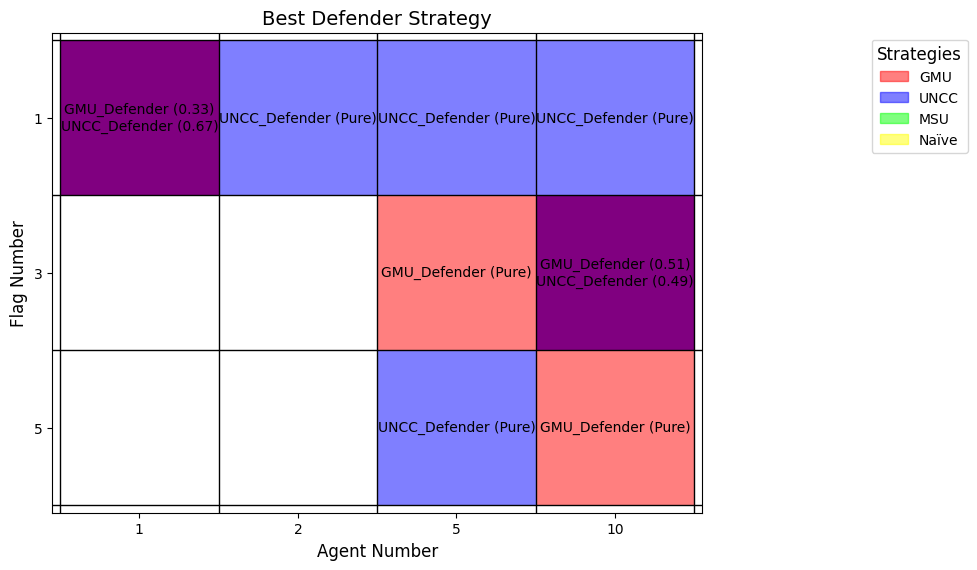

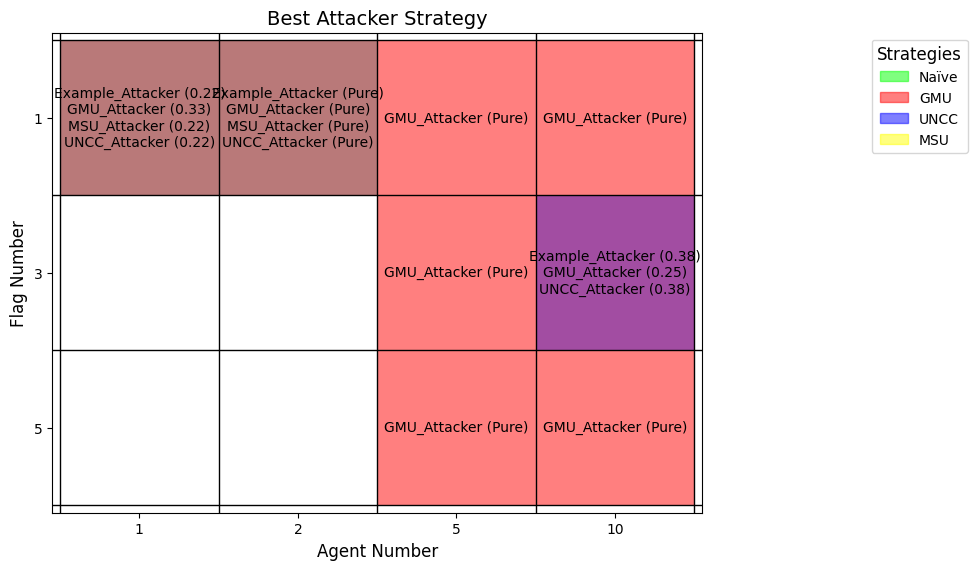

In [42]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import nashpy as nash  # This is the import you're looking for
import lib.time_logger as TLOG
from lib.core import *
# ============== Nash Equilibrium Phase Diagram (Corrected) ==============

# Define fixed transparent colors for strategies with higher alpha for better visibility
DEFENDER_COLORS = {"GMU": (1, 0, 0, 0.5), "UNCC": (0, 0, 1, 0.5), "MSU": (0, 1, 0, 0.5), "Naïve": (1, 1, 0, 0.5)}  # red  # blue  # green  # yellow
ATTACKER_COLORS = {"Naïve": (0, 1, 0, 0.5), "GMU": (1, 0, 0, 0.5), "UNCC": (0, 0, 1, 0.5), "MSU": (1, 1, 0, 0.5)}  # green  # red  # blue  # yellow


def mix_colors(color_list):
    """Average the RGB channels; boost alpha for visibility."""
    if not color_list:
        return (1, 1, 1, 0)
    r = np.mean([c[0] for c in color_list])
    g = np.mean([c[1] for c in color_list])
    b = np.mean([c[2] for c in color_list])
    # Boost alpha for better visibility but cap at 1.0
    a = min(1.0, sum(c[3] for c in color_list))
    return (r, g, b, a)


def get_strategy_base_name(strategy):
    """Extract base strategy name before any underscore."""
    if "_" in strategy:
        return strategy.split("_")[0]
    return strategy


def plot_policy_info_grid(policy_info, role, color_dict, organized_results, pure_nash_info=None, save_path=None):
    """
    Create a grid plot where x-axis is agent number and y-axis is flag number.
    For each cell (configuration), display the best strategy(ies) with their equilibrium probability.
    """
    agent_nums = sorted(set(k[0] for k in organized_results.keys()))
    flag_nums = sorted(set(k[1] for k in organized_results.keys()))

    # Handle empty cases
    if not agent_nums or not flag_nums:
        print(f"No data to plot for {role}")
        return None

    # Create figure with larger size
    fig, ax = plt.subplots(figsize=(max(4, len(agent_nums) * 2.5), max(4, len(flag_nums) * 2)))

    # Add small offset to avoid identical limits
    ax.set_xlim(-0.05, len(agent_nums) + 0.05)
    ax.set_ylim(-0.05, len(flag_nums) + 0.05)
    ax.invert_yaxis()  # So flag numbers increase upwards

    # Set tick labels
    ax.set_xticks(np.arange(len(agent_nums)) + 0.5)
    ax.set_xticklabels(agent_nums)
    ax.set_yticks(np.arange(len(flag_nums)) + 0.5)
    ax.set_yticklabels(flag_nums)

    # Draw grid lines
    for i in range(len(agent_nums) + 1):
        ax.axvline(i, color="black", linewidth=1)
    for j in range(len(flag_nums) + 1):
        ax.axhline(j, color="black", linewidth=1)

    # Create legend handles
    legend_handles = []
    for strategy_name, color in color_dict.items():
        handle = plt.Rectangle((0, 0), 1, 1, color=color)
        legend_handles.append(handle)

    # Fill in each cell
    for i, f in enumerate(flag_nums):
        for j, a in enumerate(agent_nums):
            key = (a, f)

            # Skip invalid configurations where flag_num > agent_num
            if f > a:
                continue

            if key in policy_info:
                info = policy_info[key]  # best strategy info for that configuration
                if info:
                    # Format text based on pure vs mixed Nash
                    is_pure = pure_nash_info.get(key, False) if pure_nash_info else False

                    if is_pure:
                        # Pure Nash - mark as "Pure" instead of showing 1.00
                        annot_lines = [f"{strat} (Pure)" for strat in info.keys()]
                    else:
                        # Mixed Nash - show probabilities
                        annot_lines = [f"{strat} ({prob:.2f})" for strat, prob in info.items()]

                    annot_text = "\n".join(annot_lines)

                    # Get colors for each strategy's base name
                    cell_colors = []
                    for strat in info.keys():
                        base_name = get_strategy_base_name(strat)
                        color = color_dict.get(base_name, (0.9, 0.9, 0.9, 0.3))
                        cell_colors.append(color)

                    # Mix colors for cell background
                    bg_color = mix_colors(cell_colors)
                else:
                    annot_text = "None"
                    bg_color = (1, 1, 1, 0)
            else:
                annot_text = "N/A"
                bg_color = (1, 1, 1, 0)

            # Draw background rectangle
            rect = Rectangle((j, i), 1, 1, facecolor=bg_color, edgecolor="none")
            ax.add_patch(rect)

            # Place text in center with slightly larger font
            ax.text(j + 0.5, i + 0.5, annot_text, ha="center", va="center", fontsize=10, wrap=True, linespacing=1.2)  # Increased spacing between lines

    # Add labels and title with larger font
    ax.set_xlabel("Agent Number", fontsize=12)
    ax.set_ylabel("Flag Number", fontsize=12)
    ax.set_title(f"Best {role.capitalize()} Strategy", fontsize=14)

    # Position legend farther to the right and make it more visible
    ax.legend(legend_handles, color_dict.keys(), title="Strategies", loc="upper left", bbox_to_anchor=(1.25, 1.0), fontsize=10, title_fontsize=12)  # Moved further to the right

    # Adjust layout to accommodate the legend
    plt.subplots_adjust(left=0.1, right=0.75, top=0.9, bottom=0.1)

    # Save figure
    if save_path:
        # Create directory if needed
        save_dir = os.path.dirname(save_path)
        if save_dir and not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    else:
        plt.savefig(f"{role}_best_policy_info_grid.png", dpi=300, bbox_inches="tight")

    return fig


# For pandas warning, you can fix the compute_best_strategy_info function:
def compute_best_strategy_info(organized_results):
    """
    For each (agent, flag) configuration, compute the best (equilibrium) strategies for both defender and attacker.
    Returns two dictionaries and a dictionary indicating which configurations have pure Nash equilibria.
    """
    # Suppress the degenerate game warning
    import warnings

    warnings.filterwarnings("ignore", message="An even number of .* equilibria was returned.*", category=RuntimeWarning)

    best_defender_info = {}
    best_attacker_info = {}
    pure_nash_info = {}

    for key, results_list in organized_results.items():
        # Use the first payoff matrix for the configuration
        payoff_matrix = results_list[0]["payoff_matrix"]
        if payoff_matrix.empty:
            continue

        # Check if this is a valid configuration (flag_num <= agent_num)
        agent_num, flag_num = key
        if flag_num > agent_num:
            # Skip invalid configurations
            continue

        try:
            # Fix the warning by using appropriate conversion
            A = payoff_matrix.copy()
            # Use the recommended approach
            A = A.fillna(0).astype(float).values

            # Compute Nash equilibria
            game = nash.Game(-A, A)
            equilibria = list(game.support_enumeration())

            if not equilibria:
                # No equilibria found
                best_defender_info[key] = {}
                best_attacker_info[key] = {}
                pure_nash_info[key] = False
                continue

            # Check if all equilibria are pure
            pure_equilibria = True
            for row_eq, col_eq in equilibria:
                if not (np.count_nonzero(np.isclose(row_eq, 1)) == 1 and np.count_nonzero(~np.isclose(row_eq, 0)) == 1):
                    pure_equilibria = False
                    break
                if not (np.count_nonzero(np.isclose(col_eq, 1)) == 1 and np.count_nonzero(~np.isclose(col_eq, 0)) == 1):
                    pure_equilibria = False
                    break

            if pure_equilibria:
                # For pure equilibria, every best strategy gets a score of 1
                best_defender = {}
                best_attacker = {}

                for row_eq, col_eq in equilibria:
                    idxs_def = np.where(np.isclose(row_eq, 1))[0]
                    for idx in idxs_def:
                        strat = payoff_matrix.index[idx]
                        best_defender[strat] = 1

                    idxs_att = np.where(np.isclose(col_eq, 1))[0]
                    for idx in idxs_att:
                        strat = payoff_matrix.columns[idx]
                        best_attacker[strat] = 1

                best_defender_info[key] = best_defender
                best_attacker_info[key] = best_attacker
                pure_nash_info[key] = True

            else:
                # For mixed equilibria, average the equilibrium vectors
                row_vecs = []
                col_vecs = []
                for row_eq, col_eq in equilibria:
                    row_vecs.append(row_eq)
                    col_vecs.append(col_eq)

                avg_row = np.mean(row_vecs, axis=0)
                avg_col = np.mean(col_vecs, axis=0)

                # Only include strategies with non-negligible probability
                best_defender = {strategy: prob for strategy, prob in zip(payoff_matrix.index, avg_row) if prob > 0.01}  # Small threshold to avoid numerical issues

                best_attacker = {strategy: prob for strategy, prob in zip(payoff_matrix.columns, avg_col) if prob > 0.01}  # Small threshold to avoid numerical issues

                best_defender_info[key] = best_defender
                best_attacker_info[key] = best_attacker
                pure_nash_info[key] = False

        except Exception as e:
            print(f"Error computing Nash for {key}: {str(e)}")
            best_defender_info[key] = {}
            best_attacker_info[key] = {}
            pure_nash_info[key] = False

    return best_defender_info, best_attacker_info, pure_nash_info


# Function to run the analysis
def analyze_nash_phase_diagrams(results=None, organized_results=None, save_dir=None):
    """
    Analyze Nash equilibria and create phase diagrams for attacker and defender.

    Args:
        results: Results from create_strategy_matrix (optional)
        organized_results: Results organized by agent/flag numbers (optional)
        save_dir: Directory to save images (optional)
    """
    # Use results from previous cell if not provided
    if organized_results is None and results is not None:
        print("Organizing results by agent and flag numbers...")
        organized_results = organize_by_agents_and_flags(results)

    # Compute Nash equilibria for all configurations
    print("Computing Nash equilibria...")
    best_defender_info, best_attacker_info, pure_nash_info = compute_best_strategy_info(organized_results)

    # Create save paths if directory provided
    def_path = os.path.join(save_dir, "defender_phase_diagram.png") if save_dir else None
    att_path = os.path.join(save_dir, "attacker_phase_diagram.png") if save_dir else None

    # Plot phase diagrams
    print("Plotting defender phase diagram...")
    plot_policy_info_grid(best_defender_info, "defender", DEFENDER_COLORS, organized_results, pure_nash_info, def_path)

    print("Plotting attacker phase diagram...")
    plot_policy_info_grid(best_attacker_info, "attacker", ATTACKER_COLORS, organized_results, pure_nash_info, att_path)

    return best_defender_info, best_attacker_info, pure_nash_info


# Example usage in the notebook:
best_defender_info, best_attacker_info, pure_nash_info = analyze_nash_phase_diagrams(results=results, save_dir="data/diagram")  # from previous cell  # optional